# 4.8: 量子核与懒惰态

> References:
> _Generative tensor network classification model for supervised machine learning_
> _Non-Parametric Semi-Supervised Learning in Many-Body Hilbert Space with Rescaled Logarithmic Fidelity_

## 懒惰态

GMPSC (或更一般的GTNC) 可简单地构造出NLL的极小点：

$$|\psi\rangle = \frac{1}{\sqrt{N}} \sum_{n=0}^{N-1} e^{i\theta_n}|\Phi^{(n)}\rangle$$

$|\Phi^{(n)}\rangle = \prod_{l=0}^{L-1}|\phi^{(n,l)}\rangle$，其中$|\phi^{(n,l)}\rangle$ 为第 $n$ 个样本的第 $l$ 个特征经过特征映射后得到的单比特量子态，$L$ 为每个样本的总特征数，$N$ 为总样本数；$\theta_n$ 代表第 $n$ 个样本对应的相位因子，由于 $|e^{i\theta_n}| = 1$，$\theta_n$ 的取值不影响样本出现的概率。

上述量子态满足使NLL极小的等概率分布，即

$$|\langle\Phi^{(0)}|\psi\rangle|^2 \approx |\langle\Phi^{(1)}|\psi\rangle|^2 \approx ... \approx |\langle\Phi^{(N-1)}|\psi\rangle|^2 \approx \frac{1}{N}$$

(参考4.4节)

我们将该态成为懒惰量子态 (lazy quantum state)，或简称懒惰态。

### 前提条件

等概率分布近似成立的前提：正交灾难，即两个样本量子态间的保真度满足

$$f(\boldsymbol{x}^{(n)}, \boldsymbol{x}^{(n')}) = |\langle\Phi^{(n')}|\Phi^{(n)}\rangle| \approx \delta_{n'n}$$

> $\delta$ 是一个矩阵，对角线元素为 1，非对角线元素近似为 0

此时，某个样本出现的概率满足

$$
\begin{align}
p(\boldsymbol{x}^{(n')}) 
&= |\langle\Phi^{(n')}|\psi\rangle|^2 \\
&= \frac{1}{N}\left|\sum_{n=0}^{N-1}\langle\Phi^{(n')}|e^{i\theta_n}\Phi^{(n)}\rangle\right|^2 \\
&\lesssim \frac{1}{N}\sum_{n=0}^{N-1}\left|\langle\Phi^{(n')}|e^{i\theta_n}\Phi^{(n)}\rangle\right|^2 \\
&\approx \frac{1}{N}
\end{align}
$$

例：cos-sin特征映射中 $x_l^{(n)} \rightarrow \cos\frac{\pi}{2}x_l^{(n)}|0\rangle + \sin\frac{\pi}{2}x_l^{(n)}|1\rangle$（见第三章相关内容），有

$$
\begin{align}
f(\boldsymbol{x}^{(n)}, \boldsymbol{x}^{(n')})
&= \prod_{l=0}^{L-1} (\cos\frac{\pi}{2}x_l^{(n)} \cos\frac{\pi}{2}x_l^{(n')} +  \sin\frac{\pi}{2}x_l^{(n)} \sin\frac{\pi}{2}x_l^{(n')}) \\
&= \prod_{l=0}^{L-1}\cos\frac{\pi}{2}(x_l^{(n)} - x_l^{(n')})
\end{align}
$$

保真度是由 $L$ 个小于等于1的数连乘获得，因此其值指数接近于零。

## 核函数 Kernel Function

保真度 $f(x^{(n)},x^{(n')}) = \prod_{l=0}^{L-1} \cos\frac{\pi}{2}(x_l^{(n)} - x_l^{(n')})$ 正是**余弦相似性**(cosine similarity)，为"经典"机器学习中常用的核函数(kernel function)。可见，特征映射与量子态保真度联合定义的样本相似性度量，可以是一个"经典"的相似性度量。

(注：核函数定义为从两个样本到距离度量值的半正定函数)

克服正交灾难的方法之一：发展新的核函数，例如负对数保真度

$$F(x^{(n)},x^{(n')}) = -\frac{1}{L}\ln f(x^{(n)},x^{(n')}) = -\frac{1}{L}\sum_{l=0}^{L-1}\ln\cos\frac{\pi(x_l^{(n)}-x_l^{(n')})}{2}$$

显然 $F$ 仅随 $L$ 线性变化，从而避免了正交灾难。

另一个例子：重标度对数保真度

$$f(x^{(n)},x^{(n')};\beta) = \beta^{F(x^{(n)},x^{(n')})}$$

重标度因子 $\beta$ 控制"发散"速度，一般取 $\beta > 1$。当 $\beta=e$ 时，重标度对数保真度还原为原来的保真度。

小结：
* 核函数为从两个样本到二者间测度的映射，量子核函数由**量子特征映射**与（希尔伯特空间中）量子态间的**距离测度函数**共同定义
* 可通过定义量子核函数，避免希尔伯特空间中的正交灾难，并调节样本间的相对距离
* 用不同的核函数定义可避免正交灾难，但并不影响量子态间的正交性（这里的正交性总是由内积或保真度定义），因此并不影响懒惰态的等概率分布推导


### 用量子核函数实现降维可视化

In [1]:
# |default_exp algorithms.quantum_kernel_visualization

# |export
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensor_network.utils.data import load_mnist_images
from typing import Literal

In [2]:
# parameters
cache_path = "datasets/MNIST"
classes = [0, 1, 2]
sample_num_per_class = 2000

perplexity = 20
device = torch.device("cpu")

In [3]:
data = []
labels = []

for c in classes:
    images = load_mnist_images(
        cache_path=cache_path,
        num=sample_num_per_class,
        from_subset="all",
        shuffle=True,
        classes=c,
        normalization=False,
    )
    data.append(images.reshape(images.shape[0], -1).to(device))
    labels.append(torch.full((images.shape[0],), c, device=device, dtype=torch.long))

mnist_samples = torch.cat(data, dim=0)
mnist_sample_labels = torch.cat(labels, dim=0)

#### Negative Log Likelihood with Cos-Sin Feature Mapping

In [4]:
# |export
def metric_matrix_neg_log_cos_sin(
    samples: torch.Tensor,
    theta: float = torch.pi / 2 - 1e-7,
    calculation_method: Literal["deduplicate", "no_deduplicate"] = "deduplicate",
):
    assert samples.ndim == 2  # (N samples, feature num)
    assert samples.min() >= 0.0, f"samples.min(): {samples.min()}"
    assert samples.max() <= 1.0, f"samples.max(): {samples.max()}"
    assert torch.pi / 2 >= theta >= 0.0
    assert calculation_method in ["deduplicate", "no_deduplicate"]
    sample_num = samples.shape[0]
    if calculation_method == "deduplicate":
        metric = torch.zeros(sample_num, sample_num, device=samples.device, dtype=samples.dtype)
        for n in range(sample_num - 1):
            sample_n = samples[n].reshape(1, -1)  # (1, feature num)
            others = samples[n + 1 :]  # (sample_num - n - 1, feature num)
            diff = sample_n - others  # (sample_num - n - 1, feature num)
            distances = -torch.log(torch.cos(diff * theta)).mean(dim=1)  # (sample_num - n - 1)
            assert not torch.isnan(distances).any(), "if there's nan, try to reduce theta"
            metric[n, n + 1 :] = distances
            metric[n + 1 :, n] = distances
    else:
        samples = samples.unsqueeze(0)  # (1, sample_num, feature num)
        others = samples.transpose(0, 1)  # (sample_num, 1, feature num)
        diff = samples - others  # (sample_num, sample_num, feature num)
        metric = -torch.log(torch.cos(diff * theta)).mean(dim=2)  # (sample_num, sample_num)

        for n in range(sample_num):
            metric[n, n] = 0.0

        assert not torch.isnan(metric).any(), "if there's nan, try to reduce theta"

    return metric

In [5]:
# Test
import tensor_network.setup_ref_code_import as _
from Library.MathFun import metric_matrix_neg_log_cos_sin as metric_matrix_neg_log_cos_sin_ref


sample_num = 10
samples = torch.rand(sample_num, 3)

dist_ref = metric_matrix_neg_log_cos_sin_ref(samples)

# fix a bug in the reference code, see https://github.com/ranshiju/Python-for-Tensor-Network-Tutorial/issues/10
for n in range(sample_num):
    dist_ref[n, n] = 0.0

dist = metric_matrix_neg_log_cos_sin(samples, calculation_method="no_deduplicate")

assert torch.allclose(dist, dist_ref), f"{dist_ref}"

dist = metric_matrix_neg_log_cos_sin(samples, calculation_method="deduplicate")

assert torch.allclose(dist, dist_ref), f"{dist_ref}"

#### Visualization

In [6]:
dist_euclidean = torch.cdist(mnist_samples, mnist_samples, p=2)
dist_nll_cossin = metric_matrix_neg_log_cos_sin(mnist_samples)

resc_betas = [1.01, 1.05, 1.1, 1.3]
dist_resc = {}
for beta in resc_betas:
    dist_resc[beta] = beta**dist_nll_cossin

In [7]:
# |export
def visualize_tsne(
    *,
    sample_distances: torch.Tensor,
    labels: torch.Tensor,
    perplexity: float,
    n_components: int,
    learning_rate: float | Literal["auto"] = "auto",
):
    assert sample_distances.ndim == 2
    sample_num = sample_distances.shape[0]
    assert sample_num == sample_distances.shape[1]
    assert labels.ndim == 1
    assert labels.shape[0] == sample_num
    assert sample_distances.min() >= 0.0, f"sample_distances.min(): {sample_distances.min()}"
    assert perplexity > 0.0
    assert n_components > 0
    assert learning_rate == "auto" or learning_rate > 0.0

    tsne = TSNE(
        perplexity=perplexity,
        init="random",
        n_components=n_components,
        learning_rate=learning_rate,
        metric="precomputed",
    )

    projected_samples = tsne.fit_transform(sample_distances)
    x = projected_samples[:, 0]
    x_min = x.min()
    x_max = x.max()
    x = (x - x_min) / (x_max - x_min)
    y = projected_samples[:, 1]
    y_min = y.min()
    y_max = y.max()
    y = (y - y_min) / (y_max - y_min)

    plt.figure(figsize=(4, 4))
    unique_labels = torch.unique(labels).tolist()
    colors = {l: plt.cm.tab10(l) for l in unique_labels}
    for i in range(sample_num):
        plt.text(
            x[i],
            y[i],
            str(labels[i].item()),
            color=colors[labels[i].item()],
            fontdict={"weight": "bold", "size": 9},
        )
    plt.xticks([])
    plt.yticks([])
    plt.show()

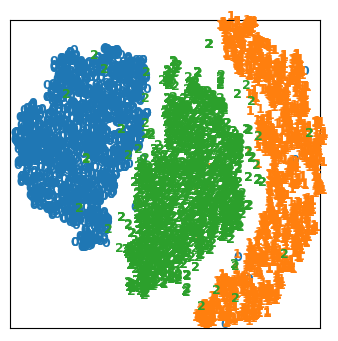

In [8]:
visualize_tsne(
    sample_distances=dist_euclidean,
    labels=mnist_sample_labels,
    perplexity=perplexity,
    n_components=2,
    learning_rate="auto",
)

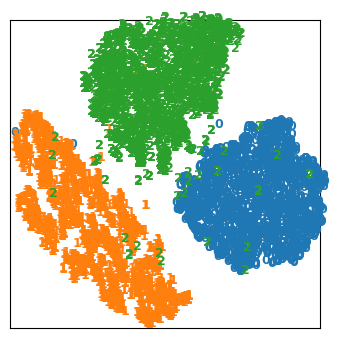

In [9]:
visualize_tsne(
    sample_distances=dist_nll_cossin,
    labels=mnist_sample_labels,
    perplexity=perplexity,
    n_components=2,
    learning_rate="auto",
)

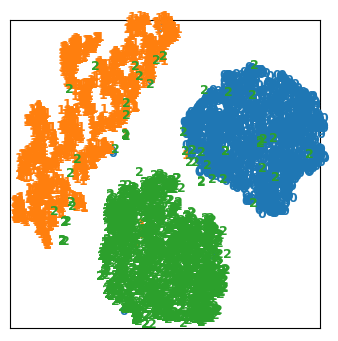

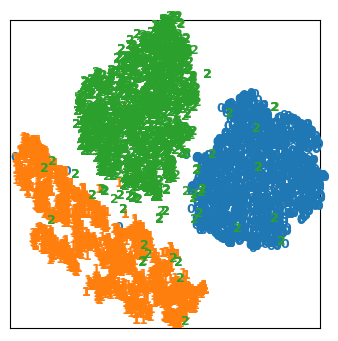

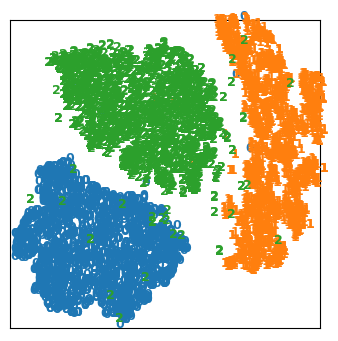

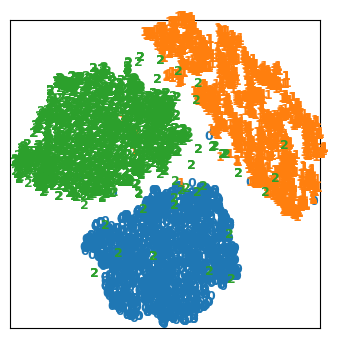

In [10]:
for beta in resc_betas:
    visualize_tsne(
        sample_distances=dist_resc[beta],
        labels=mnist_sample_labels,
        perplexity=perplexity,
        n_components=2,
        learning_rate="auto",
    )